# Project 2: Predicting House Prices with Linear Regression


**Author**: Jocelyn Lutes     [Github]()    [LinkedIn]()    [Medium]()

---

## Problem Statement

Ames, Iowa is a city in central Iowa, located approximately 37 miles from the capital city of Des Moines. In 2016, the population of Ames was approximately 65,000 residents [(1)](https://datausa.io/profile/geo/ames-ia/). Home to Iowa State University, and hosting offices for several major companies, including 3M, Barilla, Boehringer Ingelheim, and Syngenta, Ames offers a small-town feel with the amenities of a larger city [(2)](https://www.cityofames.org/about-ames/about-ames). At Ames Realty Co., we are passionate about helping our clients find a house that feels like a home. 

In the past, Ames Realty Co. has relied heavily on the opinions and expertise of our realtors to manually determine the prices of the homes that we list. However, as the industry moves to automating the appraisal of housing prices [(3)](https://unionstreetmedia.com/the-rise-of-machine-learning-in-real-estate/#:~:text=Personalized%20Marketing%20Automation%20%E2%80%93%20machine%20learning,neighborhood%20and%20property%20is%20best), we are ready to join the growing number of real estate companies that use machine learning to estimate the sales prices of their properties.

**Problem Statement:** As a member of the newly-hired data science team, I will use data collected from 2006 to 2010 to build a Linear Regression model that best predicts sale prices for properties located in Ames. 

## Executive Summary

The Ames Housing Dataset was first described in 2011 by Dean De Cock [(4)](http://jse.amstat.org/v19n3/decock.pdf). This dataset provides 81 features (of nominal, discrete, and ordinal types) to describe properties in Ames, Iowa that were sold between the years 2006-2010. During the first step in the workflow (data cleaning) missing values were fixed to the best of my abilities, correct data types were confirmed, and any unsual values were investigated. Once the data was cleaned, Exploratory Data Analysis (EDA) was conducted to explore the relationship between Sales Price and each feature in the model. For numeric features, the linear relationship was examined using a heatmap and correlation coefficients. For categorical data, bar plots were create to visualize the mean Sale Price across categories. During EDA for categorical features, special attention was paid to any patterns or clusters in Sale Prices that emerged. 

Following EDA, features were engineered to reduce dimensionality of the data and to account for the patterns and clusters that emerged during EDA. If a categorical variable was coded during feature engineering, it was removed from the data frame. Any categorical variables of interest were dummified. Data was divided into training sets (80% of data) and testing sets (20% of data) to prepare for modeling. (NOTE: For this project several models were created, including RidgeCV Regression, LassoCV Regression, and Linear Regression. For the regression models with regularization techniques, dummy variables were created for all categorical variables that had not yet been coded. For Linear Regression, dummy variables were hand-selected based on EDA and the Lasso Regression. Because different sets of dummy variables were included in the models, there are two sets of data.)

During modeling, four models were built: Null Model, RidgeCV Regression with 305 features, LassoCV Regression with 124 features, and Linear Regression with 46 features. It is important to note that all of the features included in the Linear Regression Model were determined to be important based on EDA or the LassoCV regression. The models were compared based on R2 score, and the highest scoring model was selected for further evaluation using RMSE and residuals plots. Interpretations and recommendations were made based off of the best-performing model. 

## Table of Contents
1. [Imports](#Imports)
2. [Read-in Data](#Read-in-Data)
3. [Data Dictionary](#Data-Dictionary)
4. [Data Cleaning](#Data-Cleaning)  
    - [Shape](#Check-Shape)  
    - [Cleaning Functions](#Cleaning-Functions)
    - [Missing Values](#Check-for-Null/Missing-Values)
    - [Data Types](#Check-for-Data-Types)
    - [Unsual Values](#Check-for-Unusual-Values)
    - [Clean Data](#Export-Clean-Data)  
5. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Graphing Functions](#Graphing-Functions)
    - [Correlations with Target](#Heatmap-and-Correlations-for-Target)
    - [Distributions](#Distributions-of-Variables)
    - [Categorical Variables and Target](#Visualizing-Relationships-between-Categorical-Features-and-Sales-Price)
4. [Feature Engineering](#Feature-Engineering)
    - [Combine Train + Test Data](#Combine-Train-+-Test-Datasets-to-Ensure-Equal-Features-in-Train/Test-Datasets)
    - [Functions](#Functions)
    - [Features](#Create-Features)
    - [Split Train and Test Data](#Divide-Data-Back-into-Preprocessed-Train-and-Test-Sets)
5. [Model Preparation](#Model-Preparation)
    - [Ridge and Lasso Regression](#Models-1-2:-Ridge-and-Lasso-Regression)
    - [Linear Regression](#Model-3:-Linear-Regression-Using-Handpicked-Features-Identified-by-EDA-and-Lasso)
6. [Modeling](#Modeling)
    - [Null Model](#Baseline/Null-Model)
    - [RidgeCV Regression](#Model-1:-RidgeCV-Regression)
    - [LassoCV Regression](#Model-2:-LassoCV-Regression)
    - [Linear Regression](#Model-3:-Linear-Regression-with-Features-Identified-in-EDA-and-Lasso)
7. [Model Selection](#Model-Selection)
8. [Model Evaluation](#Model-Evaluation)
9. [Conclusions and Recommendations](#Conclusions-&-Recommendations)


    

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pylab as pl

## Create a Folder for Output

In [2]:
if not os.path.isdir('output'):
    os.mkdir('output')

## Read-in Data

#### Training Data

In [3]:
housing = pd.read_csv('datasets/train.csv')
pd.set_option('display.max_columns', None)

#### Test Data

In [4]:
test = pd.read_csv('datasets/test.csv')
pd.set_option('display.max_columns', None)


## Data Dictionary

A link to the data dictionary can be found [here](https://www.kaggle.com/c/dsi-us-12-project-2-regression-challenge/data). 

## Data Cleaning

In order to ensure that all cleaning steps conducted on the training data are also conducted on the testing data, both datasets will be cleaned simultaneously.

### Check Shape

In [5]:
housing.shape

(2051, 81)

In [6]:
test.shape # One less column because missing sales price (target)

(878, 80)

In [7]:
# Calculate max number of features for training 
np.sqrt(housing.shape[0])

45.28796749689701

Because I only have 2051 rows of data, in order to avoid overfitting, I should aim to keep the number of features in my model to around 45.

### Cleaning Functions

The functions used to clean the data are listed below.

In [8]:
def check_for_nulls(df):
    '''
    Iterates over columns in the data set
    Creates a list of columns with missing values
    '''
    missing_list = []

    for column in df.columns:
        if df[column].isna().sum() > 0:
            missing_list.append(column)

    return missing_list

In [9]:
def show_na_sum(df, column):
    '''
    Shows a count of missing values in a specific column
    '''
    return df[column].isna().sum()

In [10]:
def fix_na(df, column, value):
    '''
    Fill missing data points with a specific function
    '''
    df[column] = df[column].fillna(value)

In [11]:
def change_dtype(df, column, map_fxn):
    '''
    Convert a column to a new data type
    '''
    df[column] = df[column].map(map_fxn)

### Check for Null/Missing Values

#### Generate a List of Null Values for the Training and Testing Sets

In [12]:
# Training
check_for_nulls(housing)

['Lot Frontage',
 'Alley',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'BsmtFin Type 2',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Fireplace Qu',
 'Garage Type',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Garage Qual',
 'Garage Cond',
 'Pool QC',
 'Fence',
 'Misc Feature']

In [13]:
# Testing 
check_for_nulls(test)

['Lot Frontage',
 'Alley',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Electrical',
 'Fireplace Qu',
 'Garage Type',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Pool QC',
 'Fence',
 'Misc Feature']

Above are the names for columns that contain missing data. These missing values will be cleaned below.

#### Lot Frontage

In [14]:
show_na_sum(housing, 'Lot Frontage')

330

In [15]:
housing[housing['Lot Frontage'].isna()]['MS Zoning'].value_counts()

RL    289
RM     25
FV     13
RH      3
Name: MS Zoning, dtype: int64

After exploring different features for this missing data (e.g. neighborhood, building class, zoning, lot area), it seemed like data was missing at random. Therefore null values will be filled with the mean.

In [16]:
# Clean Train Data
fix_na(housing, 'Lot Frontage', housing['Lot Frontage'].mean())

In [17]:
# Clean Test Data
fix_na(test, 'Lot Frontage', test['Lot Frontage'].mean())

#### Alley

In [18]:
show_na_sum(housing, 'Alley')

1911

In [19]:
housing['Alley'].value_counts()

Grvl    85
Pave    55
Name: Alley, dtype: int64

According to the data dictionary, 'Alley' should have three levels: Grvl, Pave, and NA. The NA (no access) variable has been replaced by NaN. The NaN will be filled with 'NA'.

In [20]:
# Fix Train Data
fix_na(housing, 'Alley', 'NA')

In [21]:
# Fix Test Data
fix_na(test, 'Alley', 'NA')

#### Masonry Veneer Type (Mas Vnr Type)

In [22]:
show_na_sum(housing, 'Mas Vnr Type')

22

In [23]:
housing['Mas Vnr Type'].value_counts()

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

Because values cannot be imputed for categorical data and the rows cannot be dropped, these values will be filled in with None.

In [24]:
# Fix Train Data
fix_na(housing, 'Mas Vnr Type', 'None')

In [25]:
# Fix Test Data
fix_na(test, 'Mas Vnr Type', 'None')

#### Masonry Veneer Area (Mas Vnr Area)

In [26]:
show_na_sum(housing, 'Mas Vnr Area')

22

In [27]:
housing[housing['Mas Vnr Type'] == 'None']['Mas Vnr Area']

2       0.0
3       0.0
4       0.0
5       0.0
8       0.0
       ... 
2046    0.0
2047    0.0
2048    0.0
2049    0.0
2050    0.0
Name: Mas Vnr Area, Length: 1240, dtype: float64

Because the values where Masonry Veneer Type is listed as 'None' have 0 area, I will fill these values with 0.

In [28]:
# Fix Train Data
fix_na(housing, 'Mas Vnr Area', 0)

In [29]:
# Fix Test Data
fix_na(test, 'Mas Vnr Area', 0)

#### Basement Quality (Bsmt Qual)

In [30]:
show_na_sum(housing, 'Bsmt Qual')

55

In [31]:
housing['Bsmt Qual'].value_counts()

TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: Bsmt Qual, dtype: int64

From the data dictionary, there should be a category 'NA' that means that a house has no basement. It was likely read-in as missing data by pandas. Missing values will be replaced with 'NA'.

In [32]:
# Fix Train Data
fix_na(housing, 'Bsmt Qual', 'NA')

In [33]:
# Fix Test Data
fix_na(test, 'Bsmt Qual', 'NA')

#### Basement Condition (Bsmt Cond)

In [34]:
show_na_sum(housing, 'Bsmt Cond')

55

In [35]:
housing['Bsmt Cond'].value_counts()

TA    1834
Gd      89
Fa      65
Po       5
Ex       3
Name: Bsmt Cond, dtype: int64

The Basement Condition should have an 'NA' value for homes without basements.

In [36]:
# Fix Train Data
fix_na(housing, 'Bsmt Cond', 'NA')

In [37]:
# Fix Test Data
fix_na(test, 'Bsmt Cond', 'NA')

#### Bsmt Exposure

In [38]:
show_na_sum(housing, 'Bsmt Exposure')

58

In [39]:
housing['Bsmt Exposure'].value_counts()

No    1339
Av     288
Gd     203
Mn     163
Name: Bsmt Exposure, dtype: int64

There are only 55 houses listed as NA but 58 missing values here. For now, I will just fill these values in with 'NA'. 

In [40]:
# Fix Train Data
fix_na(housing, 'Bsmt Exposure', 'NA')

In [41]:
# Fix Test Data
fix_na(test, 'Bsmt Exposure', 'NA')

#### Quality of Basement Finished Area 1 (BsmtFin Type 1)

In [42]:
show_na_sum(housing, 'BsmtFin Type 1')

55

In [43]:
housing['BsmtFin Type 1'].value_counts()

GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: BsmtFin Type 1, dtype: int64

In [44]:
# Fix Train Data
fix_na(housing, 'BsmtFin Type 1', 'NA')

In [45]:
# Fix Test Data
fix_na(test, 'BsmtFin Type 1', 'NA')

#### Quality of Basement Finished Area 2 (BsmtFin Type 2)

In [46]:
show_na_sum(housing, 'BsmtFin Type 2')

56

In [47]:
housing['BsmtFin Type 2'].value_counts()

Unf    1749
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: BsmtFin Type 2, dtype: int64

In [48]:
# Fix Train Data
fix_na(housing, 'BsmtFin Type 2', 'NA')

In [49]:
# Fix Test Data
fix_na(test, 'BsmtFin Type 2', 'NA')

#### Fireplace Quality (Fireplace Qu)

In [50]:
show_na_sum(housing, 'Fireplace Qu')

1000

In [51]:
housing[housing['Fireplaces']==0]['Fireplace Qu'].count()

0

Because there are 1000 houses listed as having 0 fireplaces and NaN for Fireplace Quality, I think that I can safely assume that the missing values should be 'NA'.

In [52]:
# Fix Train Data
fix_na(housing, 'Fireplace Qu', 'NA')

In [53]:
# Fix Test Data
fix_na(test, 'Fireplace Qu', 'NA')

#### Garage Type

In [54]:
show_na_sum(housing, 'Garage Type')

113

In [55]:
housing[housing['Garage Area']==0]['Id'].count()

113

In [56]:
housing['Garage Type'].value_counts()

Attchd     1213
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64

The Garage Type column should have an 'NA' value to denote that properties do not have a garage.

In [57]:
# Fix Train Data
fix_na(housing, 'Garage Type', 'NA')

In [58]:
# Fix Test Data
fix_na(test, 'Garage Type', 'NA')

#### Garage Yr Built

In [59]:
show_na_sum(housing, 'Garage Yr Blt')

114

In [60]:
mask1 = housing['Garage Area'] != 0
mask2 = housing['Garage Yr Blt'].isna()

housing[mask1 & mask2]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1712,2237,910201180,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NA,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,150909


There is one house listed as having a detached garage tht is missing data for all other garage qualities. For now, these qualities will be listed as 'NA', but I might revisit it later.

In [61]:
# Fix Train Data
fix_na(housing, 'Garage Yr Blt', 'NA')

In [62]:
# Fix Test Data
fix_na(test, 'Garage Yr Blt', 'NA')

#### Garage Finish

In [63]:
show_na_sum(housing, 'Garage Finish')

114

Garage Finish should have an 'NA' column for properties with no garage.

In [64]:
# Fix Train Data
fix_na(housing, 'Garage Finish', 'NA')

In [65]:
# Fix Test Data
fix_na(test, 'Garage Finish', 'NA')

#### Garage Quality (Garage Qual)

In [66]:
show_na_sum(housing, 'Garage Qual')

114

Garage Quality should have an 'NA' column for properties with no garage.

In [67]:
# Fix Train Data
fix_na(housing, 'Garage Qual', 'NA')

In [68]:
# Fix Test Data
fix_na(test, 'Garage Qual', 'NA')

#### Garage Condition (Garage Cond)

In [69]:
show_na_sum(housing, 'Garage Cond')

114

Garage Condition should have an 'NA' column for properties with no garage.

In [70]:
# Fix Train Data
fix_na(housing, 'Garage Cond', 'NA')

In [71]:
# Fix Test Data
fix_na(test, 'Garage Cond', 'NA')

#### Pool QC

In [72]:
show_na_sum(housing, 'Pool QC')

2042

In [73]:
housing['Pool QC'].value_counts()

Gd    4
Fa    2
TA    2
Ex    1
Name: Pool QC, dtype: int64

In [74]:
housing[housing['Pool Area'] == 0]['Id'].count()

2042

In [75]:
housing[housing['Pool Area'] == 0].count()['Id']/housing['Pool Area'].count()

0.9956118966357874

Almost 99.6% of the houses in the train data do not have pools. These missing values will be coded as 'NA' (No Pool). 

In [76]:
# Fix Train Data
fix_na(housing, 'Pool QC', 'NA')

In [77]:
# Fix Test Data
fix_na(test, 'Pool QC', 'NA')

#### Fence

In [78]:
show_na_sum(housing, 'Fence')

1651

In [79]:
housing['Fence'].value_counts()

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64

The Fence column should have an 'NA' column for properties with no garage.

In [80]:
# Fix Train Data
fix_na(housing, 'Fence', 'NA')

In [81]:
# Fix Test Data
fix_na(test, 'Fence', 'NA')

#### Miscellanous Feature (Misc Feature)

In [82]:
show_na_sum(housing, 'Misc Feature')

1986

In [83]:
housing['Misc Feature'].value_counts()

Shed    56
Gar2     4
Othr     3
TenC     1
Elev     1
Name: Misc Feature, dtype: int64

The Miscellaneous Feature column should have an 'NA' column for properties with no garage.

In [84]:
# Fix Train Data
fix_na(housing, 'Misc Feature', 'NA')

In [85]:
# Fix Test Data
fix_na(test, 'Misc Feature', 'NA')

#### Square Feet of Finished Basement 1 (Basmt Fin SF 1)

In [86]:
show_na_sum(housing, 'BsmtFin SF 1')

1

In [87]:
housing[housing['BsmtFin SF 1'].isna()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1327,1342,903230120,20,RM,99.0,5940,Pave,NA,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NA,NA,NA,NA,NaN,NA,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NA,Detchd,1946,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NA,MnPrv,NA,0,4,2008,ConLD,79000


This property does not appear to have a basement.

In [88]:
fix_na(housing, 'BsmtFin SF 1', 0)

In [89]:
show_na_sum(housing, 'BsmtFin SF 1')

0

#### Square Feet of Finished Basement 2 (BsmtFin SF 2)

This missing value is the same as in Square Feet of Finished Basement 1.

In [90]:
show_na_sum(housing, 'BsmtFin SF 2')

1

In [91]:
fix_na(housing, 'BsmtFin SF 2', 0)

#### Square Feet of Unfinished Basement (BsmtUnfSF)

This missing value is the same as in Square Feet of Finished Basement 1.

In [92]:
show_na_sum(housing, 'Bsmt Unf SF')

1

In [93]:
fix_na(housing, 'Bsmt Unf SF', 0)

#### Total Basement Square Feet (Total Bsmt SF)

This missing value is the same as in Square Feet of Finished Basement 1.

In [94]:
show_na_sum(housing, 'Total Bsmt SF')

1

In [95]:
fix_na(housing, 'Total Bsmt SF', 0)

#### Remaining NaN Values

Because all of the missing values in the training data were for the same house, I decided to fill na by row.

In [96]:
housing.loc[1327, :].fillna(0)

Id                   1342
PID             903230120
MS SubClass            20
MS Zoning              RM
Lot Frontage           99
                  ...    
Misc Val                0
Mo Sold                 4
Yr Sold              2008
Sale Type           ConLD
SalePrice           79000
Name: 1327, Length: 81, dtype: object

#### Electrical (Test Data Only)

In [97]:
show_na_sum(test, 'Electrical')

1

In [98]:
test[test['Electrical'].isna()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
634,1578,916386080,80,RL,73.0,9735,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NA,BuiltIn,2007,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NA,NA,NA,0,5,2008,WD


Because I did not want to explore the test data, I filled this missing value with the most common type of electrical.

In [99]:
fix_na(test, 'Electrical', 'SBrkr') # Fill with most common; Also standard optiono

#### Basement (Bsmt) Full Bath and Half Bath

In [100]:
housing[housing['Bsmt Full Bath'].isna()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
616,1498,908154080,20,RL,123.0,47007,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NA,NA,NA,0,7,2008,WD,284700
1327,1342,903230120,20,RM,99.0,5940,Pave,NA,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NA,Detchd,1946,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NA,MnPrv,NA,0,4,2008,ConLD,79000


These properties do not appear to have basements so can be filled with 0.

In [101]:
fix_na(housing, 'Bsmt Full Bath', 0)

In [102]:
fix_na(housing, 'Bsmt Half Bath', 0)

#### Garage Cars & Garage Area

In [103]:
show_na_sum(housing, ['Garage Cars', 'Garage Area'])

Garage Cars    1
Garage Area    1
dtype: int64

In [104]:
housing[housing['Garage Cars'].isna()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1712,2237,910201180,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NA,Detchd,NA,NA,NaN,NaN,NA,NA,Y,174,0,212,0,0,0,NA,MnPrv,NA,0,3,2007,WD,150909


This property does not appear to have a garage so can be folled with xzero.

In [105]:
fix_na(housing, ['Garage Cars', 'Garage Area'], 0)

#### Check for Nulls #3

In [106]:
check_for_nulls(housing)

[]

All null values have been cleaned.

### Check for Data Types

In [107]:
# housing.info()

#### Convert Int to String ('Id', 'PID', MS SubClass)

In [108]:
int_to_string = ['Id', 'PID', 'MS SubClass']

for item in int_to_string:
    change_dtype(housing, item, str)

#### Convert Month Int to Month Name

In [109]:
months = {1: 'January',
         2: 'February',
         3: 'March',
         4: 'April',
         5: 'May',
         6: 'June',
         7: 'July',
         8: 'August',
         9: 'September',
         10: 'October',
         11: 'November',
         12: 'December'}

change_dtype(housing, 'Mo Sold', months)

### Check for Unusual Values

#### Numerical Values

In [110]:
housing.describe()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,98.626524,442.084837,47.935641,567.451487,1057.471965,1164.488055,329.329108,5.512921,1499.330083,0.427109,0.063384,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1.775719,473.440761,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,2007.775719,181469.701609
std,21.306357,6742.488909,1.426271,1.104497,30.177889,21.036250,174.324690,461.195041,164.964052,445.022846,449.908003,396.446923,425.671046,51.068870,500.447829,0.522589,0.251590,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,0.765357,216.135102,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,1.312014,79258.659352
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006.000000,12789.000000
25%,60.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,129825.000000
50%,69.055200,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.000000,994.000000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,162500.000000
75%,78.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,159.000000,733.500000,0.000000,811.000000,1318.500000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000,214000.000000
max,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,2010.000000,611657.000000


In [111]:
# Investigate any values that seem out of the orinary

housing[housing['SalePrice'] == housing['SalePrice'].min()] # Quality is poor, seems to be okay

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1628,182,902207130,30,RM,68.0,9656,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,2,1923,1970,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,BrkTil,Fa,Fa,No,Unf,0.0,Unf,0.0,678.0,678.0,GasA,TA,N,SBrkr,832,0,0,832,0.0,0.0,1,0,2,1,TA,5,Typ,1,Gd,Detchd,1928,Unf,2.0,780.0,Fa,Fa,N,0,0,0,0,0,0,NA,NA,NA,0,June,2010,WD,12789


#### Categorical Values

In [112]:
#https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical

categorical_vars = housing.select_dtypes(exclude = ['number'])

In [113]:
categorical_vars.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating',
       'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish',
       'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence',
       'Misc Feature', 'Mo Sold', 'Sale Type'],
      dtype='object')

Identified Concerns:
* Neighborhood: Greens (3), GrnHill (2), and Landmark (1) not listed as possible values in data dictionary.

### Export Clean Data

In [114]:
housing.to_csv('./datasets/train_clean')

In [115]:
test.to_csv('./datasets/test_clean')

## Exploratory Data Analysis

### Graphing Functions

In [116]:
def create_scatter(df, x_col, y_col, title, x_label, y_label, marker_size = 4, color='mediumseagreen', plot_size = (10,6), hue = None):
    plt.figure(figsize=plot_size)
    ax = sns.scatterplot(x = x_col, y = y_col, data = df, s=marker_size, color=color, hue = hue)
    plt.title(title, fontdict = {'fontsize': 14})
    plt.xlabel(x_label, fontdict = {'fontsize':13})
    plt.ylabel(y_label, fontdict = {'fontsize':13})
    plt.tight_layout;
    return ax

In [117]:
def create_hist(feature, num_bins, title, x_label, y_label, color='royalblue', edgecolor='black', plot_size = (10,6)):
    plt.figure(figsize=plot_size)
    feature.hist(bins = num_bins, color=color, edgecolor=edgecolor, grid = False)
    plt.title(title, fontdict = {'fontsize': 14})
    plt.xlabel(x_label, fontdict = {'fontsize':13})
    plt.ylabel(y_label, fontdict = {'fontsize':13})
    plt.tight_layout;

In [219]:
def create_bar_xticks(df, x_col, y_col, title, x_label, y_label, hue=None, color = 'mediumseagreen', plot_size = (10,6), lw = 1.5, x_tick_labels = None, palette = None):
    plt.figure(figsize=plot_size)
    ax = sns.barplot(x = x_col, y = y_col, data = df, hue = hue, color = color, linewidth = lw, edgecolor = 'black', palette = palette)
    plt.title(title, fontdict = {'fontsize': 14})
    plt.xlabel(x_label, fontdict = {'fontsize':13})
    plt.ylabel(y_label, fontdict = {'fontsize':13})
    ax.set_xticklabels(x_tick_labels)
    plt.tight_layout;

In [119]:
def create_bar(df, x_col, y_col, title, x_label, y_label, hue=None, color = 'mediumseagreen', plot_size = (10,6), lw = 1.5):
    plt.figure(figsize=plot_size)
    ax = sns.barplot(x = x_col, y = y_col, data = df, hue = hue, color = color, linewidth = lw, edgecolor = 'black')
    plt.title(title, fontdict = {'fontsize': 14})
    plt.xlabel(x_label, fontdict = {'fontsize':13})
    plt.ylabel(y_label, fontdict = {'fontsize':13})
    plt.tight_layout;

In [120]:
def create_count(df, x_col, title, x_label, color = 'mediumseagreen', plot_size = (10,6)):
    plt.figure(figsize = plot_size)
    sns.countplot(x=x_col, data = df, palette = 'viridis')
    plt.title(title, fontdict= {'fontsize':14})
    plt.xlabel(f'Number of {x_label} per Property', fontdict= {'fontsize':12})
    plt.ylabel('Number of Properties', fontdict= {'fontsize':12})

### Create a Date Frame with Proper Variable Names

In [121]:
vis_df = housing.copy()

In [122]:
# Rename columns to be more readable for heatmap
vis_df.rename(columns = {
    'MS SubClass':'Building Class',
    'MS Zoning': 'Zoning Class',
    'Street' : 'Street Type',
    'Lot Config':'Lot Configuration',
    'Condition1': 'Proximity to Main Road or Railroad 1',
    'Condition 2' : 'Proximity to Main Road or Railroad 2',
    'BldgType':'Building Type',
    'Overall Qual': 'Overall Quality',
    'Overall Cond': 'Overall Condition',
    'Year Remod/Add': 'Remodel Date',
    'Roof Matl': 'Roof Material',
    'Exterior 1st':'Exterior Covering 1',
    'Exterior 2nd': 'Exterior Covering 2',
    'Mas Vnr Type': 'Masonry Veneer Type',
    'Mas Vnr Area': 'Masonry Veneer Area',
    'Exter Qual': 'Exterior Material Quality',
    'Exter Cond': 'Exterior Condition Quality',
    'Bsmt Qual':'Basement Quality',
    'Bsmt Cond': 'Basement Condition', 
    'Basmt Exposure': 'Basement Exposure',
    'BsmtFin Type 1': 'Quality of Finished Basement 1',
    'BsmtFin Type 2': 'Quality of Finished Basement 2',
    'BsmtFin SF 1': 'Square Feet of Finished Basement 1',
    'BsmtFin SF 2': 'Square Feet of Finished Basement 2',
    'Bsmt Unf SF': 'Square Feet of Unfinished Basement',
    'Total Bsmt SF': 'Total Basement Square Feet',
    'Heating': 'Heating Type',
    'Heating QC': 'Heating Quality and Condition',
    '1st Flr SF': '1st Floor Square Feet',
    '2nd Flr SF': '2nd Floor Square Feet',
    'Low Qual Fin SF':'Low Quality Finished Square Feet',
    'Gr Liv Area': 'Above-Grade Living Area',
    'Bsmt Full Bath': 'Basement Full Bathrooms',
    'Bsmt Half Bath': 'Basement Half Bathrooms',
    'Full Bath': 'Full Bathrooms',
    'Half Bath': 'Half Bathrooms',
    'Bedroom': 'Bedrooms',
    'Kitchen':'Kitchens',
    'Kitchen Qual': 'Kitchen Quality', 
    'TotRms AbvGrd': 'Total Rooms Above Grade',
    'Functional':'Functionality',
    'Fireplace Qu': 'Fireplace Quality',
    'Garage Yr Blt': "Year Garage Built",
    'Garage Finish': 'Interior Finish of Garage',
    'Garage Cars': 'Size of Garage (Cars)',
    'Garage Area': 'Size of Garage (Square Feet)',
    'Garage Qual':'Garage Quality',
    'Garage Cond': 'Garage Condition',
    'Paved Drive': 'Extent of Driveway Pavement', 
    'Wood Deck SF': 'Wood Deck Square Feet',
    'Open Porch SF': 'Open Porch Square Feet',
    'Enclosed Porch': 'Enclosed Porch Square Feet',
    '3Ssn Porch': '3 Season Porch Square Feet', 
    'Screen Porch': 'Screen Porch Square Feet',
    'Pool Area': 'Pool Area (Square Feet)',
    'Pool QC': 'Pool Quality',
    'Fence':'Fence Quality',
    'Misc Feature':'Miscellaneous Feature',
    'Misc Val': 'Value of Miscellaneous Feature',
    'Mo Sold': 'Month Sold',
    'Yr Sold': 'Year Sold',
    'SalePrice': 'Sale Price'
}, inplace = True);

### Heatmap and Correlations for Target

In [123]:
corr_matrix = vis_df.corr()[['Sale Price']].sort_values('Sale Price')

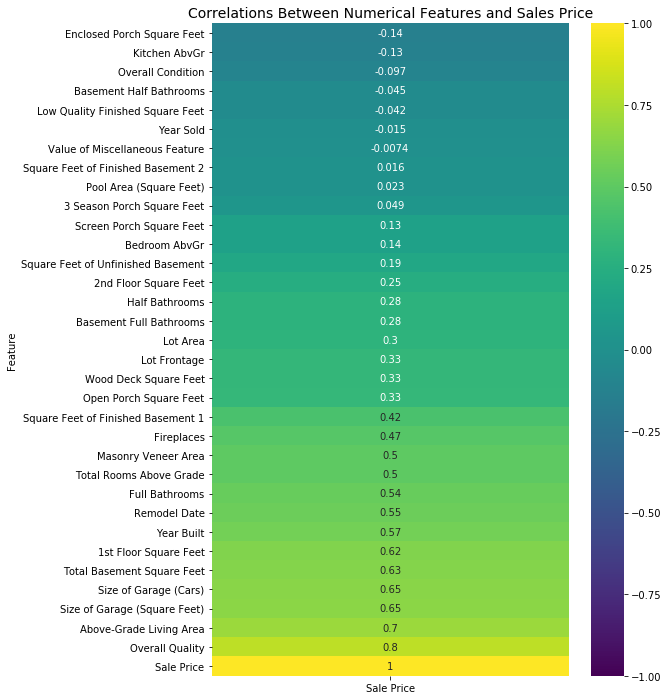

In [124]:
plt.figure(figsize=(8, 12))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = 'viridis')
plt.title('Correlations Between Numerical Features and Sales Price', fontdict={'fontsize':14})
plt.ylabel('Feature');

In [125]:
corr_target = abs(corr_matrix)
salient_num_features = corr_target.loc[corr_target['Sale Price'] > 0.5, :]
salient_num_features

,Sale Price
Masonry Veneer Area,0.503579
Total Rooms Above Grade,0.504014
Full Bathrooms,0.537969
Remodel Date,0.550370
Year Built,0.571849
1st Floor Square Feet,0.618486
Total Basement Square Feet,0.629303
Size of Garage (Cars),0.647781
Size of Garage (Square Feet),0.649897
Above-Grade Living Area,0.697038


Above, we are able to see that 'Mas Vnr Area', 'Total Rooms Above Ground', 'Full Baths', 'Year of Remodeling or Additions', 'Year Built', '1st Floor Square', 'Total Basement Sq Footage', 'Number of Cars for the Garage', 'Garage Area', 'Above Grade Living Area', and 'Overall Quality' are the features most highly correlated with Sale Price.

### Distributions of Variables

#### Target (Sale Price)

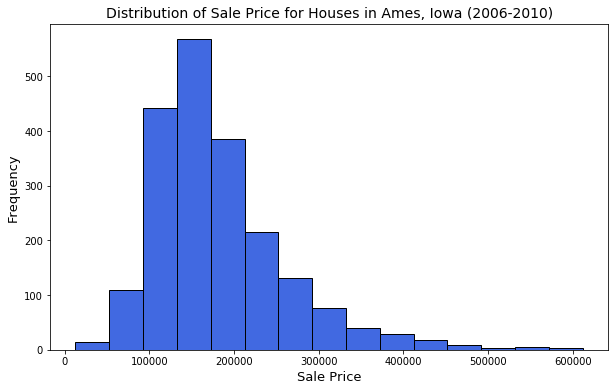

In [126]:
create_hist(housing['SalePrice'], 
            num_bins = 15, 
            title = 'Distribution of Sale Price for Houses in Ames, Iowa (2006-2010)',
           x_label = 'Sale Price',
           y_label = 'Frequency')

The distribution for the target is not normally distributed. It has a right skew. When creating my linear regression model, I might want to consider logging y.

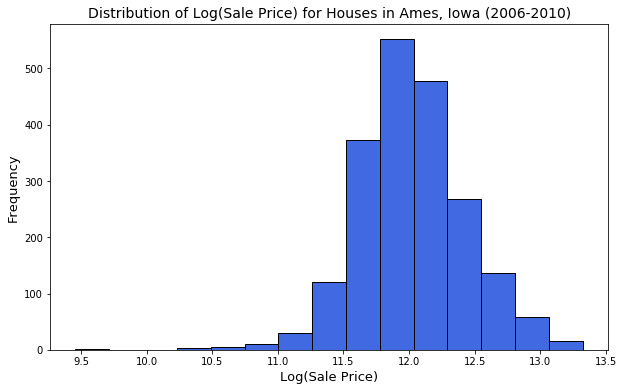

In [127]:
create_hist(np.log(housing['SalePrice']), 
            num_bins = 15, 
            title = 'Distribution of Log(Sale Price) for Houses in Ames, Iowa (2006-2010)',
           x_label = 'Log(Sale Price)',
           y_label = 'Frequency')

Logging the distribution helps normalize the data a little, but now there is a slight left skew.

#### Features

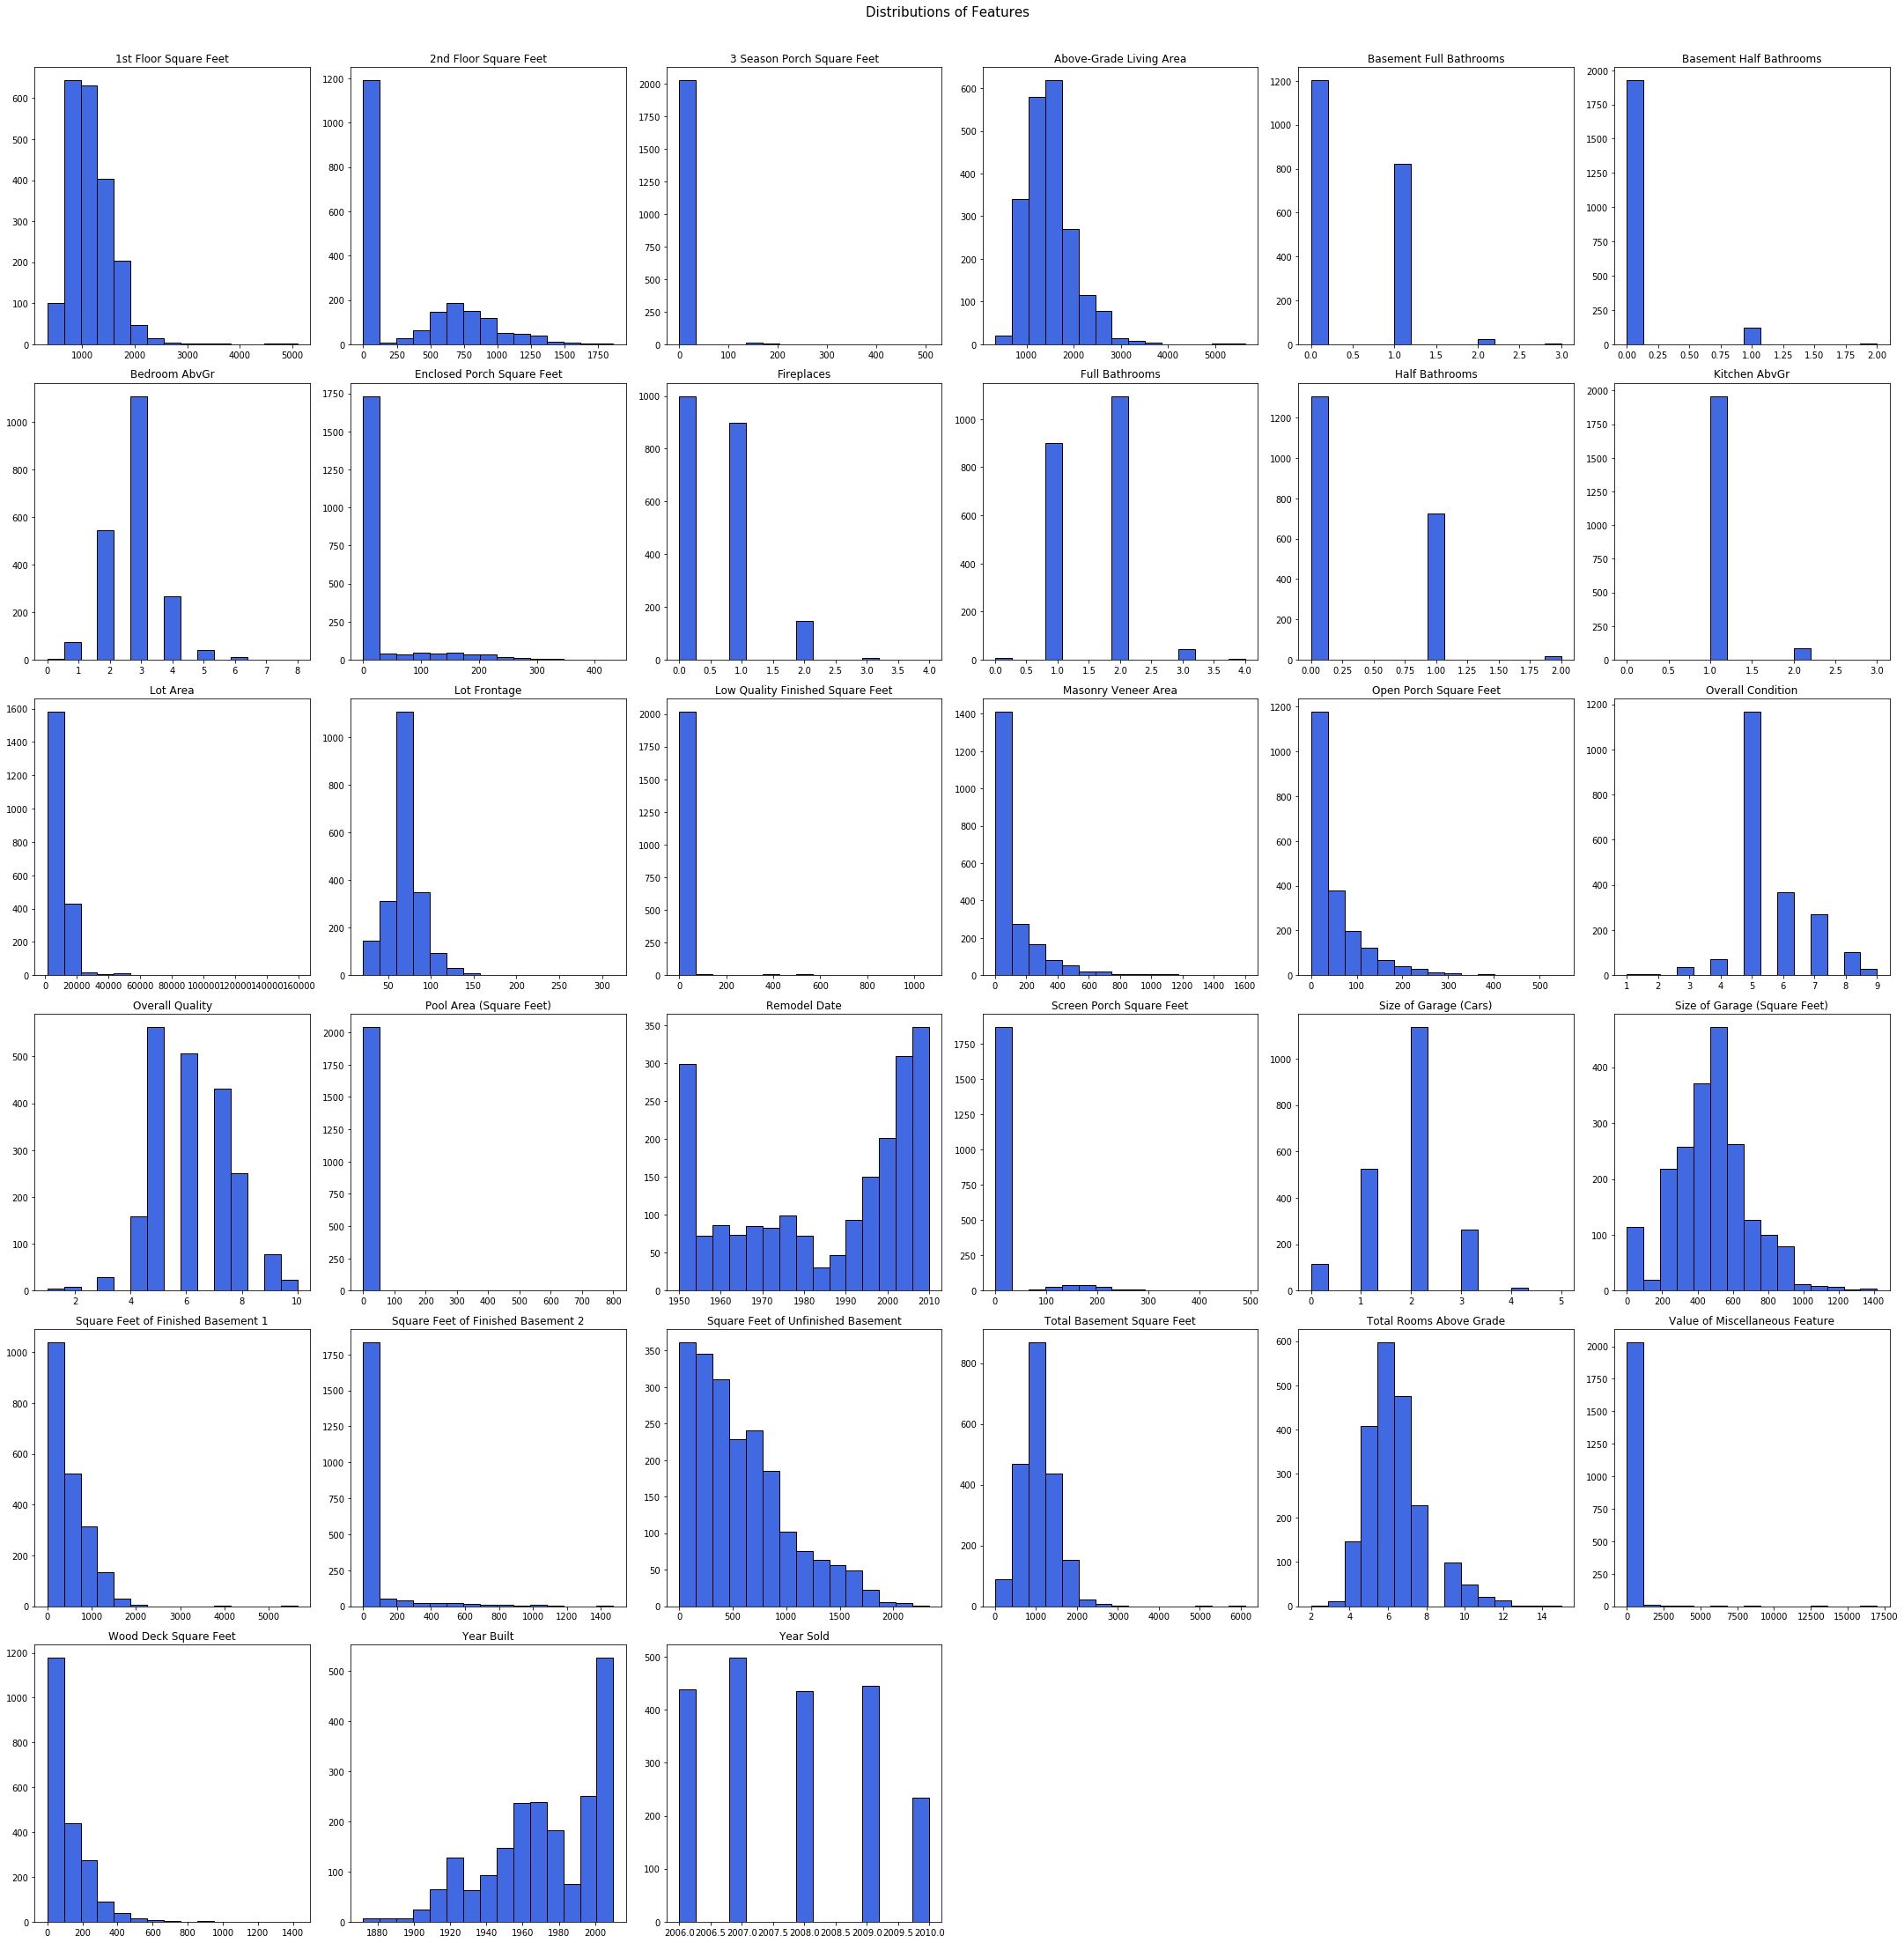

In [216]:
vis_df.drop(columns='Sale Price').hist(figsize=(30, 30), bins = 15, edgecolor = 'black', grid = False, color = 'royalblue')
pl.suptitle('Distributions of Features', x = 0.5, y = 1.02, size = 15)
plt.tight_layout();

#https://stackoverflow.com/questions/19614400/add-title-to-collection-of-pandas-hist-plots
#https://stackoverflow.com/questions/55767312/how-to-position-suptitle

The above plots show the distributions for each variable. These plots were created as a quick visual to assess the normality of the data. As shown above, the distributions for the majority of numeric features do not appear to be normally distributed.

### Visualizing Relationships between Categorical Features and Sales Price

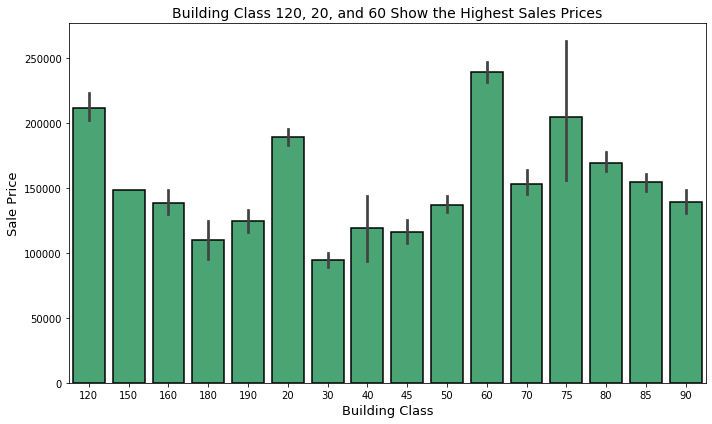

In [129]:
create_bar(housing, 
          'MS SubClass', 
          'SalePrice', 
          title='Building Class 120, 20, and 60 Show the Highest Sales Prices', 
          x_label = 'Building Class', 
          y_label = 'Sale Price',
       )
plt.tight_layout()

In the above graph, we can see that Building Classes 120 (1-Story Planned Development Unit), 20 (1-Story 1946 and newer), and 60 (2-Story 1946 & Newer) result in significantly increased sales prices. These building classes might be important features for predicting the price of a building in Ames, Iowa.

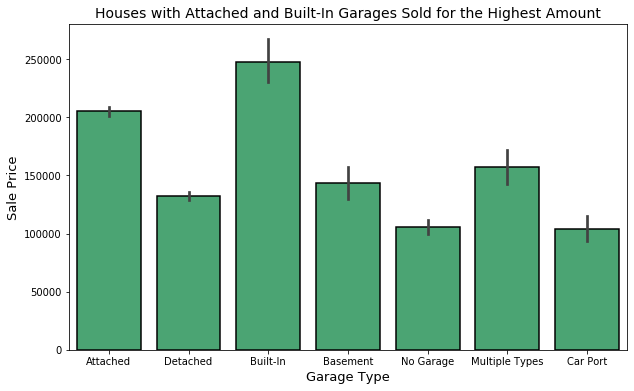

In [130]:
create_bar_xticks(housing, 
                  'Garage Type', 
                  'SalePrice', 
                  title='Houses with Attached and Built-In Garages Sold for the Highest Amount', 
                  x_label = 'Garage Type', 
                  y_label = 'Sale Price', 
                  x_tick_labels =['Attached', 'Detached', 'Built-In', 'Basement', 'No Garage', 'Multiple Types', 'Car Port'])

Houses with built-in garages had the highest sales prices. Built-in garages also have living space above them, so in addition to adding value through a garage, they can also add value through more liveable space.

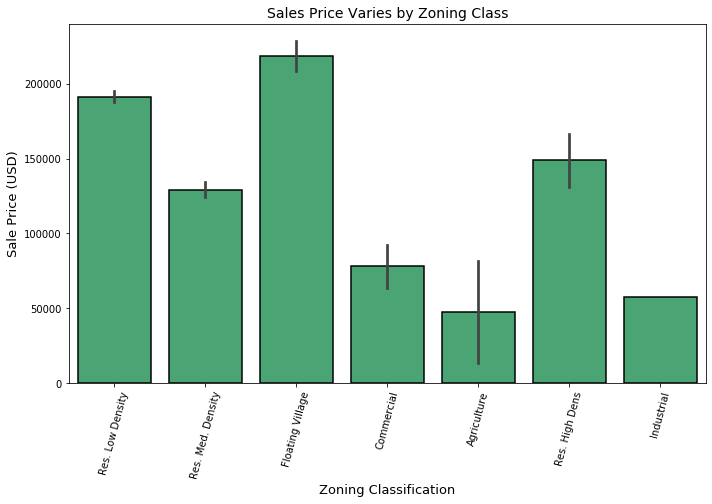

In [131]:
create_bar_xticks(housing, 
           'MS Zoning', 
           'SalePrice', 
            title='Sales Price Varies by Zoning Class', 
            x_label = 'Zoning Classification',
            y_label = 'Sale Price (USD)',
            x_tick_labels = ['Res. Low Density', 'Res. Med. Density', 'Floating Village', 'Commercial', 'Agriculture', 'Res. High Dens', 'Industrial'])
plt.tight_layout()
plt.xticks(rotation = 75);


From this figure, we can see that Zoning Classification appears to result in vastly different sales prices. However, two similar levels appear.Grouping properties from Res. Low Density, Floating Villages, and Res. High Density areas together could be a could feature in predicting price.

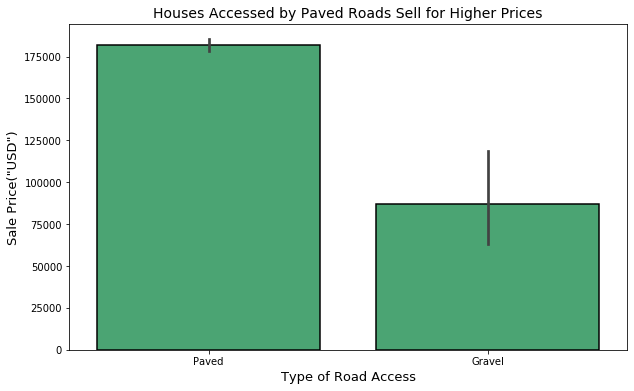

In [132]:
create_bar_xticks(housing, 
           'Street', 
           'SalePrice', 
            title='Houses Accessed by Paved Roads Sell for Higher Prices', 
            x_label = 'Type of Road Access',
            y_label = 'Sale Price("USD")',
            x_tick_labels = ['Paved', 'Gravel'])

From this figure, it appears that having access to the property via a paved road results in the house selling for a higher price than accessing the property via a gravel road.

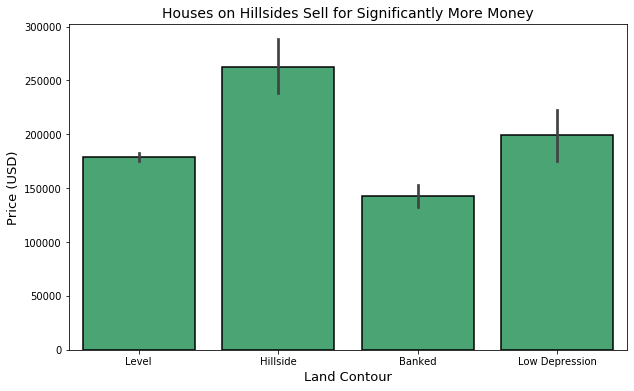

In [133]:
create_bar_xticks(housing, 
           'Land Contour', 
           'SalePrice', 
            title='Houses on Hillsides Sell for Significantly More Money', 
            x_label = 'Land Contour',
            y_label = 'Price (USD)',
            x_tick_labels = ['Level', 'Hillside', 'Banked', 'Low Depression'])

From the above figure, we can see that houses on the hillside sell for the most money, while houses that are banked (steep rise from the street to the building) sell or the least amount of money. 

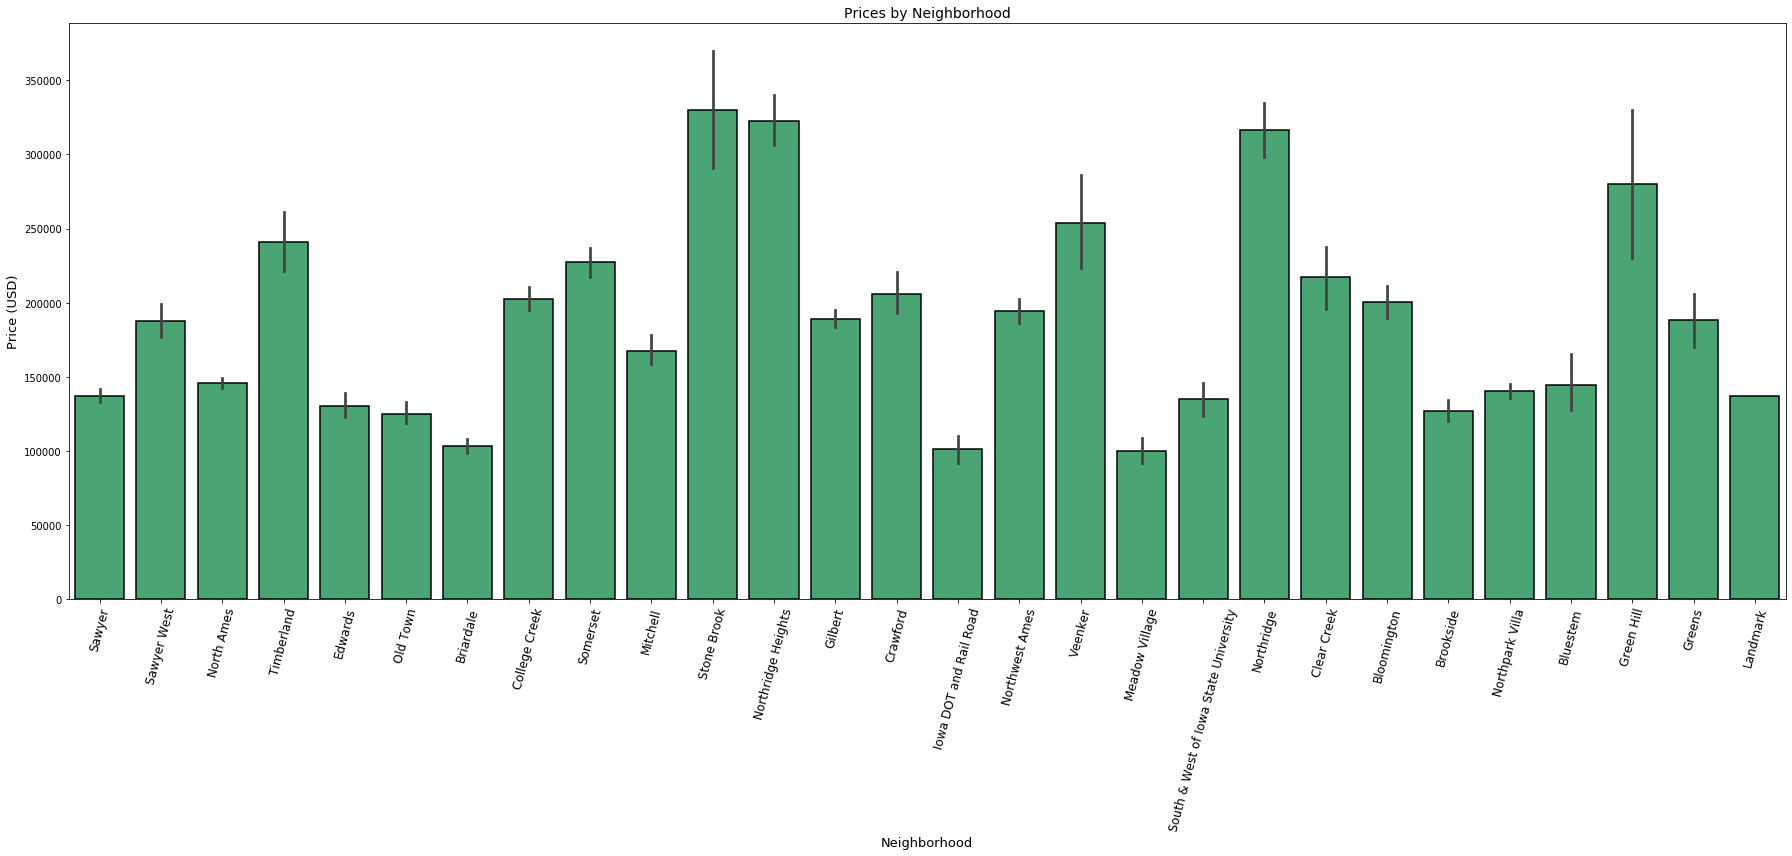

In [134]:
create_bar_xticks(housing, 
           'Neighborhood', 
           'SalePrice', 
            title='Prices by Neighborhood', 
            x_label = 'Neighborhood',
            y_label = 'Price (USD)',
          plot_size = (25,12),
            x_tick_labels = ['Sawyer', 'Sawyer West', 'North Ames', 'Timberland', 'Edwards', 'Old Town', 'Briardale', 'College Creek', 'Somerset', 'Mitchell', 'Stone Brook', 'Northridge Heights', 'Gilbert', 'Crawford', 'Iowa DOT and Rail Road', 'Northwest Ames', 'Veenker', 'Meadow Village', 'South & West of Iowa State University', 'Northridge', 'Clear Creek', 'Bloomington', 'Brookside', 'Northpark Villa', 'Bluestem', 'Green Hill', 'Greens', 'Landmark'])
plt.xticks(size=12, rotation = 75)
plt.tight_layout();

Neighborhood definitely seems to impact the price of a property. However, creating dummy variables for each neighborhood will introduce too many features into our model. Because we seem to see three ranges of peaks in this figure, I will later engineer features to capture this variation.

* Group 1 - Stone Brook, Northridge Heights, Veenker, Northridge, Green Hill
* Group 2 - Sawyer West, Timber, College Creek, Somerset, Gilbert, Crawford, Northwest Ames, Cleark Creek, Bloomington, Greens
* Group 3 - All Others

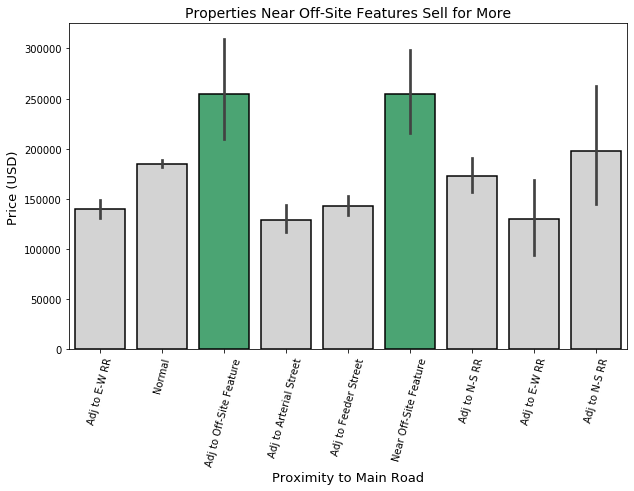

In [221]:
create_bar_xticks(housing, 
           'Condition 1', 
           'SalePrice', 
            title='Properties Near Off-Site Features Sell for More', 
            x_label = 'Proximity to Main Road',
            y_label = 'Price (USD)',
            x_tick_labels = ['Adj to E-W RR', 'Normal', 'Adj to Off-Site Feature', 'Adj to Arterial Street', 'Adj to Feeder Street', 'Near Off-Site Feature', 'Adj to N-S RR', 'Adj to E-W RR', ' Adj to N-S RR'],
            palette = ['lightgray', 'lightgray', 'mediumseagreen','lightgray','lightgray','mediumseagreen','lightgray','lightgray','lightgray']
            )
plt.xticks(rotation = 75);


From this graph, we are able to see that Sale Prices increase if the property is near a positive off-site feature. Likewise, prices are less if the property is near an arterial or feeder street. 

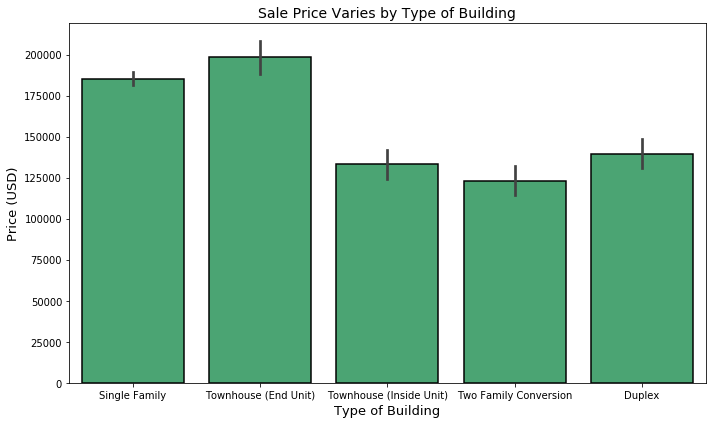

In [136]:
create_bar_xticks(housing, 
           'Bldg Type', 
           'SalePrice', 
            title='Sale Price Varies by Type of Building', 
            x_label = 'Type of Building',
            y_label = 'Price (USD)',
            x_tick_labels = ['Single Family', 'Townhouse (End Unit)', 'Townhouse (Inside Unit)', 'Two Family Conversion', 'Duplex'])
plt.tight_layout()

From this figure, we can see that single family homes and townhouses that are end units sell for the most money.

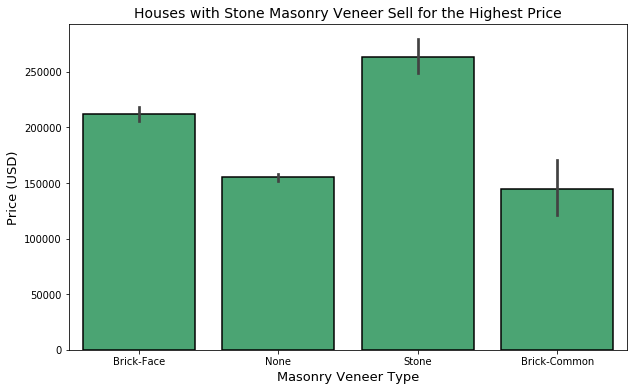

In [137]:
create_bar_xticks(housing, 
           'Mas Vnr Type', 
           'SalePrice', 
            title='Houses with Stone Masonry Veneer Sell for the Highest Price', 
            x_label = 'Masonry Veneer Type',
            y_label = 'Price (USD)',
          x_tick_labels = ['Brick-Face', 'None', 'Stone', 'Brick-Common'])

From this figure, it appears that houses with stone veneers sell for substantially more.

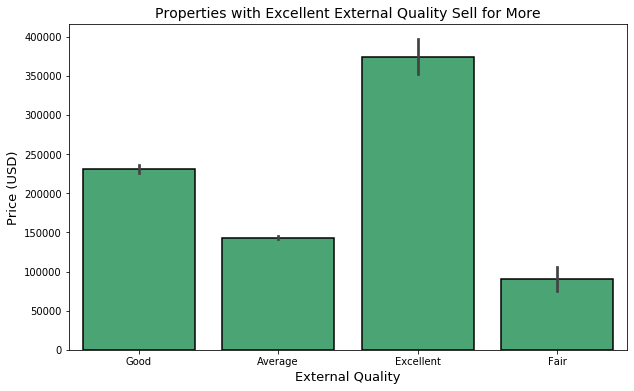

In [138]:
create_bar_xticks(housing, 
           'Exter Qual', 
           'SalePrice', 
            title='Properties with Excellent External Quality Sell for More', 
            x_label = 'External Quality',
            y_label = 'Price (USD)',
            x_tick_labels = ['Good', 'Average', 'Excellent', 'Fair']
          )

From this figure, it appears that the quality of the materials on the exterior of the house impacts price. Houses with excellent quality sell for substantially more. 

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

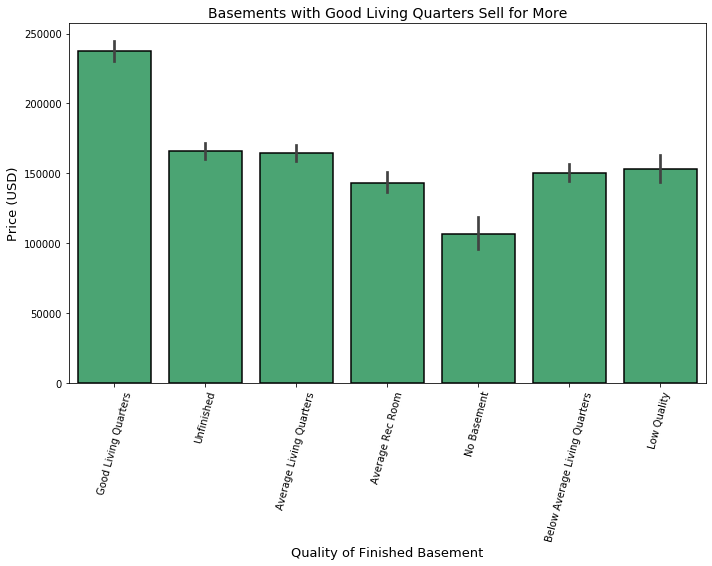

In [139]:
create_bar_xticks(housing, 
           'BsmtFin Type 1', 
           'SalePrice', 
            title='Basements with Good Living Quarters Sell for More', 
            x_label = 'Quality of Finished Basement',
            y_label = 'Price (USD)',
            x_tick_labels = ['Good Living Quarters', 'Unfinished', 'Average Living Quarters', 'Average Rec Room', 'No Basement', 'Below Average Living Quarters', 'Low Quality'])
plt.tight_layout();
plt.xticks(rotation=75)

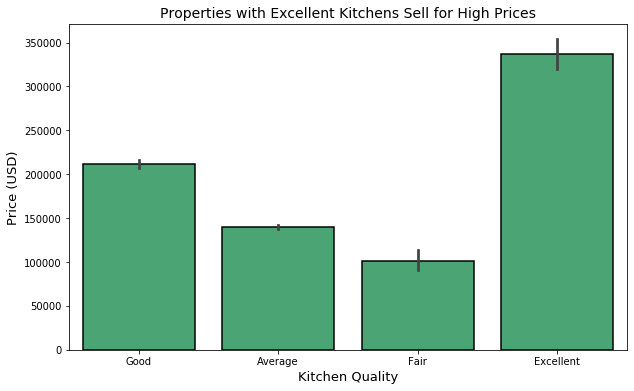

In [140]:
create_bar_xticks(housing, 
           'Kitchen Qual', 
           'SalePrice', 
            title='Properties with Excellent Kitchens Sell for High Prices', 
            x_label = 'Kitchen Quality',
            y_label = 'Price (USD)',
            x_tick_labels = ['Good', 'Average', 'Fair', 'Excellent'])

In this figure, we see that houses with excellent quality kitchens sell for more.

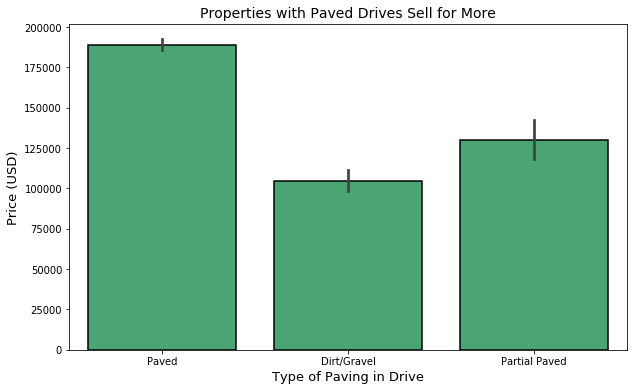

In [141]:
create_bar_xticks(housing, 
           'Paved Drive', 
           'SalePrice', 
            title='Properties with Paved Drives Sell for More', 
            x_label = 'Type of Paving in Drive',
            y_label = 'Price (USD)',
            x_tick_labels = ['Paved', 'Dirt/Gravel', 'Partial Paved'])

Properties with paved access sell for substantially more.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

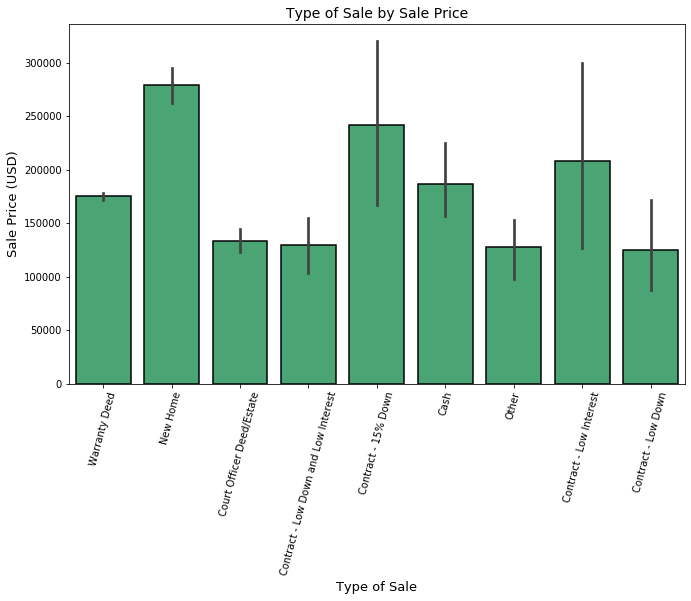

In [142]:
create_bar_xticks(housing, 
           'Sale Type', 
           'SalePrice', 
            title='Type of Sale by Sale Price', 
            x_label = 'Type of Sale',
            y_label = 'Sale Price (USD)',
            x_tick_labels = ['Warranty Deed', 'New Home', 'Court Officer Deed/Estate', 'Contract - Low Down and Low Interest','Contract - 15% Down', 'Cash', 'Other', 'Contract - Low Interest', 'Contract - Low Down'])
plt.tight_layout();
plt.xticks(rotation = 75)

From this figure, we can see that New Homes sell for the most.

## Feature Engineering

### Combine Train + Test Datasets to Ensure Equal Features in Train/Test Datasets

In [143]:
# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data

train_index_marker = len(housing)

train_and_test = pd.concat(objs=[housing, test], axis = 0)
train_and_test.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,69.0552,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NA,Attchd,1976,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NA,NA,NA,0,March,2010,WD,130500.0
1,544,531379050,60,RL,43.0000,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NA,NA,NA,0,April,2009,WD,220000.0
2,153,535304180,20,RL,68.0000,7922,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NA,Detchd,1953,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NA,NA,NA,0,January,2010,WD,109000.0


### Functions

In [144]:
def create_total_baths(df):
    df['total_baths'] = df['Full Bath'] + df['Bsmt Full Bath'] + 0.5 * (df['Bsmt Half Bath'] + df['Half Bath'])

In [145]:
def drop_baths_columns(df):
    '''
    Drops columns used to create "Total Baths" feature
    '''
    df.drop(columns = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'Full Bath'], inplace = True)

In [146]:
def create_liveable_sf(df):
    df['liveable_sf'] = df['BsmtFin SF 1'] + df['BsmtFin SF 2'] + df['Gr Liv Area']

In [147]:
def drop_liveable_sf_columns(df):
    '''
    Drops all columns directly related to "Liveable SF" feature
    '''
    df.drop(columns = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Gr Liv Area', '1st Flr SF', '2nd Flr SF'], inplace = True)

### Create Features

#### Create a feature for total number of baths per home

In [148]:
create_total_baths(train_and_test)

In [149]:
drop_baths_columns(train_and_test)

#### Create a feature for total livable sq feet in the house

In [150]:
create_liveable_sf(train_and_test)

In [151]:
drop_liveable_sf_columns(train_and_test)

#### Explore if a 'Garage' Feature Can Be Built

In [152]:
train_and_test.columns[train_and_test.columns.str.contains('Garage')]

Index(['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond'],
      dtype='object')

In [153]:
# Correlation of Garage Area with Sale Price (Training Data Only)
housing.corr()['Garage Area']['SalePrice']

0.649896849661898

In [154]:
# Correlation of Garage Cars with Sale Price (Training Data Only)
housing.corr()['Garage Cars']['SalePrice']

0.6477813459587413

In [155]:
# Correlation between Garage Area and Garage Cars
housing.corr()['Garage Area']['Garage Cars']

0.8934415694476694

Because the area of the garage and the number of cars that a garage can fit are highly correlated, I will create an interaction feature to account for this relationship.

In [156]:
housing['garage_area_car_int'] = housing['Garage Area'] * housing['Garage Cars']

Because the interaction feature is more highly correlated than either of the other features, we will also add this feature to our full dataset. 

In [157]:
train_and_test['garage_area_car_int'] = train_and_test['Garage Area'] * train_and_test['Garage Cars']

#### Create Two Neighborhood Features Based on Clusters from Bar Plot

In the bar plot of Average Sale Price by Neighborhood, I noticed about three clusters of neighborhoods with sales prices that were in a similar range. To eliminate adding a dummy variable for each individual neighborhood, I will create two dummy variables to encode inclusion in these clusters. 

In [158]:
group1 = ['StoneBr', 'NridgeHt', 'Veenker', 'NoRidge', 'GrnHill']
group2 = ['SawyerW', 'CollgCr', 'Somerst', 'Gilbert', 'Crawfor', 'NAmes', 'ClearCr', 'Blmngtn', 'Greens']

train_and_test['neighborhoods_1'] = train_and_test['Neighborhood'].map(lambda name: 1 if name in group1 else 0)
train_and_test['neighborhoods_2'] = train_and_test['Neighborhood'].map(lambda name: 1 if name in group2 else 0)

In [159]:
train_and_test.drop(columns = 'Neighborhood', inplace = True)

#### Create Three Building Class Features

From the bar graph showing average sales prices by MS SubClass, I noticed that three classes seemed to be distinguishing features. Therefore, I have engineered features to be able to include these classes in my model without dummifying the entire set. 

In [160]:
train_and_test['SubClass20'] = train_and_test['MS SubClass'].map(lambda subclass: 1 if subclass == 20 else 0)
train_and_test['SubClass60'] = train_and_test['MS SubClass'].map(lambda subclass: 1 if subclass == 60 else 0)
train_and_test['SubClass120'] = train_and_test['MS SubClass'].map(lambda subclass: 1 if subclass == 120 else 0)

In [161]:
train_and_test.drop(columns = 'MS SubClass', inplace = True)

#### Create a feature to represent if a property is close to an off-site feature or an arterial or feeder street

In [162]:
train_and_test['close_to_offsite_feature'] = train_and_test['Condition 1'].map(lambda x: 1 if x in ['PosN', 'PosA'] else 0)

In [163]:
train_and_test['close_to_busy_street'] = train_and_test['Condition 1'].map(lambda x: 1 if x in ['Artery', 'Feedr'] else 0)

In [164]:
train_and_test.drop(columns = 'Condition 1', inplace = True)

#### Create a feature to determine if masonry veneer type is stone

In [165]:
train_and_test['stone_veneer'] = train_and_test['Mas Vnr Type'].map(lambda x: 1 if x == 'Stone' else 0)

In [166]:
train_and_test.drop(columns = 'Mas Vnr Type', inplace = True)

#### Create a feature to code if the type of sale is for a new home

In [167]:
train_and_test['new_sale'] = train_and_test['Sale Type'].map(lambda x: 1 if x == 'New' else 0)

#### Create a feature to code if the sale is an estate transaction

In [168]:
train_and_test['new_sale'] = train_and_test['Sale Type'].map(lambda x: 1 if x == 'COD' else 0)

In [169]:
train_and_test.drop(columns = 'Sale Type', inplace = True)

#### Create a feature to denote good living quarters in the basement

In [170]:
train_and_test['good_basement'] = train_and_test['BsmtFin Type 1'].map(lambda x: 1 if x == 'GLQ' else 0)

In [171]:
train_and_test.drop(columns = 'BsmtFin Type 1', inplace = True)

#### Create a feature to denote excellent or good kitchen quality

In [172]:
train_and_test['excellent_kitchen'] = train_and_test['Kitchen Qual'].map(lambda x: 1 if x == 'Ex' else 0)

In [173]:
train_and_test.drop(columns = 'Kitchen Qual', inplace = True)

#### Create a column to denote zoning clusters

In [174]:
train_and_test['zoning_cluster_1'] = train_and_test['MS Zoning'].map(lambda x: 1 if x in ['FV', 'RL', 'RH'] else 0)

In [175]:
train_and_test.drop(columns = 'MS Zoning', inplace = True)

#### Create dummy variables for categorical features of interest identified in EDA

For this project, I created several models, including: Linear Regression, Ridge Regression, and Lasso Regression. For the Ridge and Lasso Regression models, I dummied all categorical variables that had not been somehow coded into the model. For Linear Regression, I hand-selected features based on what I found in the EDA and Lasso Regression. Therefore, because different dummy variables are required for the two models, I will work off of two sets of data.

**Models 1-2** - Model with All Remaining Features Dummied (Used for Ridge and Lasso Regression)

In [176]:
# Drop features that have already been coded
dropped_cats = ['Id', 'PID', 'Kitchen Qual', 'BsmtFin Type 1', 'Sale Type', 'Mas Vnr Type', 'Condition 1', 'MS SubClass', 'Neighborhood', 'MS Zoning']

In [177]:
dummify_list_1 = [category for category in categorical_vars if category not in dropped_cats]

In [178]:
train_and_test_1 = pd.get_dummies(data = train_and_test, columns = dummify_list_1, drop_first = True)

**Model 3** - Linear Regression with Handpicked Features

In [179]:
# Dummify hand-selected features
dummify_list_3 = ['Street', 'Land Contour', 'Bldg Type', 'Garage Type', 'Exter Qual', 'Paved Drive']

In [180]:
train_and_test_3 = pd.get_dummies(data = train_and_test, columns = dummify_list_3, drop_first = True)

### Divide Data Back into Preprocessed Train and Test Sets

#### Models 1-2: Ridge and Lasso Regression

In [181]:
# Split into Train
train_preprocessed_1 = train_and_test_1[:train_index_marker]

In [182]:
# Split into Test
test_preprocessed_1 = train_and_test_1[train_index_marker:]

#### Model 3: Linear Regression with Handpicked Features

In [183]:
# Split into Train
train_preprocessed_3 = train_and_test_3[:train_index_marker]

In [184]:
# Split into Test
test_preprocessed_3 = train_and_test_3[train_index_marker:]

In [185]:
train_preprocessed_3.head()

,Id,PID,Lot Frontage,Lot Area,Alley,Lot Shape,Utilities,Lot Config,Land Slope,Condition 2,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,Low Qual Fin SF,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,SalePrice,total_baths,liveable_sf,garage_area_car_int,neighborhoods_1,neighborhoods_2,SubClass20,SubClass60,SubClass120,close_to_offsite_feature,close_to_busy_street,stone_veneer,new_sale,good_basement,excellent_kitchen,zoning_cluster_1,Street_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Paved Drive_P,Paved Drive_Y
0,109,533352170,69.0552,13517,NA,IR1,AllPub,CulDSac,Gtl,Norm,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,289.0,TA,CBlock,TA,TA,No,Unf,192.0,725.0,GasA,Ex,Y,SBrkr,0,3,1,6,Typ,0,NA,1976,RFn,2.0,475.0,TA,TA,0,44,0,0,0,0,NA,NA,NA,0,March,2010,130500.0,2.5,2012.0,950.0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
1,544,531379050,43.0000,11492,NA,IR1,AllPub,CulDSac,Gtl,Norm,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,132.0,TA,PConc,Gd,TA,No,Unf,276.0,913.0,GasA,Ex,Y,SBrkr,0,4,1,8,Typ,1,TA,1997,RFn,2.0,559.0,TA,TA,0,74,0,0,0,0,NA,NA,NA,0,April,2009,220000.0,3.5,2759.0,1118.0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2,153,535304180,68.0000,7922,NA,Reg,AllPub,Inside,Gtl,Norm,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,0.0,Gd,CBlock,TA,TA,No,Unf,326.0,1057.0,GasA,TA,Y,SBrkr,0,3,1,5,Typ,0,NA,1953,Unf,1.0,246.0,TA,TA,0,52,0,0,0,0,NA,NA,NA,0,January,2010,109000.0,2.0,1788.0,246.0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
3,318,916386060,73.0000,9802,NA,Reg,AllPub,Inside,Gtl,Norm,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,0.0,TA,PConc,Gd,TA,No,Unf,384.0,384.0,GasA,Gd,Y,SBrkr,0,3,1,7,Typ,0,NA,2007,Fin,2.0,400.0,TA,TA,100,0,0,0,0,0,NA,NA,NA,0,April,2010,174000.0,2.5,1444.0,800.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
4,255,906425045,82.0000,14235,NA,IR1,AllPub,Inside,Gtl,Norm,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,0.0,TA,PConc,Fa,Gd,No,Unf,676.0,676.0,GasA,TA,Y,SBrkr,0,3,1,6,Typ,0,NA,1957,Unf,2.0,484.0,TA,TA,0,59,0,0,0,0,NA,NA,NA,0,March,2010,138500.0,2.0,1445.0,968.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


## Model Preparation

### Models 1-2: Ridge and Lasso Regression

In [186]:
X_1 = train_preprocessed_1.drop(columns = ['SalePrice', 'zoning_cluster_1']) # Drop Zoning Cluster - Was Created After Lasso
y_1 = train_preprocessed_1['SalePrice']

In [187]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = 0.2, random_state = 1990)

In [188]:
X_holdout_1 = test_preprocessed_1.drop(columns = ['SalePrice', 'zoning_cluster_1'])

### Model 3: Linear Regression Using Handpicked Features Identified by EDA and Lasso

In [189]:
cols_to_drop = ['Id', 'PID', 'Utilities', 'Lot Config', 'Land Slope', 'Condition 2', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 2', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Yr Blt', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Pool QC', 'Fence', 'Misc Feature', 'Misc Val', 'SalePrice', 'Alley', 'Lot Shape','Foundation', 'Mo Sold', 'Low Qual Fin SF', 'Roof Matl']

X_3 = train_preprocessed_3.drop(columns = cols_to_drop)
y_3 = np.log(train_preprocessed_3['SalePrice']) # log y to normalize distribution!

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.2, random_state = 42)

X_holdout_3 = test_preprocessed_3.drop(columns = cols_to_drop)

## Modeling

### Functions

In [190]:
def display_R2_scores(model, X_train, y_train, X_test, y_test):
    print(f'The mean cross validation score for the Lasso Regression is {round(cross_val_score(model, X_train, y_train).mean(),4)}.')
    print(f'The training score for the Lasso Regression is {round(model.score(X_train, y_train), 4)}.')
    print(f'The testing score for the Lasso Regression is {round(model.score(X_test, y_test),4)}.')

### Baseline/ Null Model

#### Instantiate and Fit Model

In [191]:
dr = DummyRegressor()

In [192]:
dr.fit(X_train_1, y_train_1);

#### Evaluate R2 Scores

In [193]:
display_R2_scores(dr, X_train_1, y_train_1, X_test_1, y_test_1)

The mean cross validation score for the Lasso Regression is -0.007.
The training score for the Lasso Regression is 0.0.
The testing score for the Lasso Regression is -0.0001.


#### Thoughts on the Model

In this scenario, just predicting the mean Sale Price will explain ~0% of the variation in our target. Any model that is able to explain any variation in the target will be a vast improvement.

---
### Model 1: RidgeCV Regression

**NOTE:** Prior to conducting any of the regularization techniques, a Linear Regression was fit to the data. As expected, the model was highly overfit (training R2: 0.94, test R2: 0.77). Because the model was verified to be overfit, I wanted to use Ridge Regularization to trade bias for variance.

#### Scale the Data (Can also be used with LASSO)

In [194]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train_1)
Z_test = ss.transform(X_test_1)
scaled_holdout = ss.transform(X_holdout_1)

#### Instantiate and Fit the Model

In [195]:
# Create a list of alphas
ridge_alphas = np.logspace(-5, 5, 100)
ridge_cv = RidgeCV(alphas = ridge_alphas, scoring = 'r2', cv = 5)
ridge_cv = ridge_cv.fit(Z_train, y_train_1)

# Code taught by Tim Book

In [196]:
# Determine best value of alpha
ridge_cv.alpha_

599.4842503189409

#### Evaluate R2 Scores

In [197]:
display_R2_scores(ridge_cv, Z_train, y_train_1, Z_test, y_test_1)
print(f'The number of features in this model is : {np.sum(ridge_cv.coef_ != 0)}.')

The mean cross validation score for the Lasso Regression is 0.8448.
The training score for the Lasso Regression is 0.9022.
The testing score for the Lasso Regression is 0.8257.
The number of features in this model is : 305.


#### Thoughts on Model

Overall, although this model did improve upon the Linear Regression with the same data (test R2 = 0.77). I was surprised by how poorly this model performed. It has low bias but high variance and remains overfit. It is only able to explain ~82.6% of variation in the target (Sale Price). It also still has 305 features in the model. In order to improve this model, I might consider looking at the coefficients and removing some features from the model before building another Ridge Regression. 

---
### Model 2: LassoCV Regression

#### Instantiate and Fit the Model

In [198]:
lasso_alphas = np.logspace(0, 5, 100)
lasso_cv = LassoCV(alphas = lasso_alphas, cv = 5, max_iter = 4000)
lasso_cv.fit(Z_train, y_train_1);

# Code taught by Tim Book

In [199]:
# Determine the best value of alpha
lasso_cv.alpha_

533.6699231206308

#### Evaluate R2 Scores

In [200]:
display_R2_scores(lasso_cv, Z_train, y_train_1, Z_test, y_test_1)
print(f'The number of features in this model is : {np.sum(lasso_cv.coef_ != 0)}.')

The mean cross validation score for the Lasso Regression is 0.8459.
The training score for the Lasso Regression is 0.9151.
The testing score for the Lasso Regression is 0.8068.
The number of features in this model is : 124.


#### Look at Coefficients that Remain in Model

In [201]:
# Code from Jose Portilla's Data Science Class on Udemy
lasso_coef = pd.DataFrame(lasso_cv.coef_, X_train_1.columns, columns = ['Coefficient'])
pd.set_option('display.max_rows', None)

In [202]:
# COMMENTED OUT TO PREVENT CLOGGING NOTEBOOK!
# Only select coefficients that Lasso kept
# lasso_coef[lasso_coef['Coefficient'] != 0].sort_values('Coefficient', ascending = False)

#### Thoughts on Model

I was surprised that the LassoCV Regression remained overfit after it reduced the number of features from 305 to 124. The training R2 was able to explain 91.5% of variation in Sale Price, but the testing R2 is only able to explain 80.7%. To improve this model, I would likely manually remove features that have been assigned 0 coefficients and rerun the LassoCV until the model is no longer overfit to the training data.

### Model 3: Linear Regression with Features Identified in EDA and Lasso

#### Instantiate and Fit Model

In [203]:
lr1 = LinearRegression()

In [204]:
lr1.fit(X_train_3, y_train_3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Evaluate R2 Scores

In [205]:
display_R2_scores(lr1, X_train_3, y_train_3, X_test_3, y_test_3)
print(f'The number of features in this model is : {np.sum(lr1.coef_ != 0)}.')

The mean cross validation score for the Lasso Regression is 0.8449.
The training score for the Lasso Regression is 0.8744.
The testing score for the Lasso Regression is 0.8782.
The number of features in this model is : 46.


#### Thoughts on Model

Of the models that I created, this one performs the best in terms of R2 score. There is low bias and low variance. With only 46 features, this model explains approximately 87% of the variation in the target (Sales Price) for both the training and testing sets. Because the data has not been scaled, this data also provides the best interpretability. 

#### [For Kaggle] Make Predictions to Holdout Data and Save to CSV

In [206]:
# y was logged; Must exponentiate the predictions
lr1_preds = np.exp(lr1.predict(X_holdout_3))

In [207]:
preds_cols = pd.Series(lr1_preds, name = 'SalePrice')
id_col = test_preprocessed_1['Id']
output = pd.concat([id_col, preds_cols], axis = 1)
output.sort_values('Id', inplace = True)
output.sort_values('Id', inplace = True)
output.set_index('Id', inplace = True)
output.to_csv('./output/final_submission')

## Model Selection

In [208]:
# (For HTML Code Below) https://stackoverflow.com/questions/21892570/ipython-notebook-align-table-to-the-left-of-cell

In [209]:
%%html
<style>
table{float:left}
</style>

Model Name | Training Score | Testing Score
-|-|-
Baseline/Null Model|0%|0%
Ridge|90.2%|82.3%
LASSO|91.5%|80.7%
Linear Regression|87.4%|87.8%

As shown in this table, of each of the models that I built, the Linear Regression that was built performed the best in terms of R2 score, and it was also not overfit. In the next section, I will further evaluate this model.

## Model Evaluation

I will further evaluate the Linear Regression model by calculating the Root Mean Squared Error and by examining the residuals. In order to increase interpretability, the logged y-values will be exponentiated for model evaluation. 

### Root Mean Squared Error (RMSE)

In [210]:
y_test = np.exp(y_test_3) # Convert back to actual values
y_pred = np.exp(lr1.predict(X_test_3)) # Convert back to actual values
resids = y_test - y_pred

In [211]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'The RMSE is {round(rmse,2)}.')

The RMSE is 23673.28.


According to the value of the RMSE, the predictions for Sale Price made by the Linear Regression model are likely off by about $23,673.28. This is less than 1/3 of the standard deviation of the Sale Price in the training data. Although I would like to improve this number to increase the predictability of the model, this is a good starting point to improve from. 

### How do the predictions of Sale Price compare to the actual values?

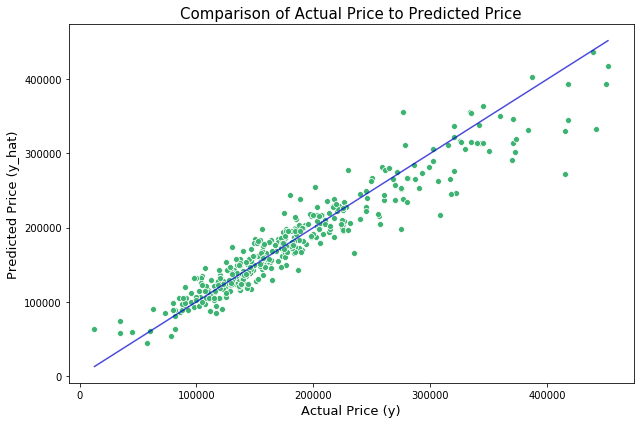

In [212]:
plt.figure(figsize = (9, 6))
sns.scatterplot(x = y_test, y = y_pred, color = 'mediumseagreen')
plt.title('Comparison of Actual Price to Predicted Price', fontdict = {'fontsize':15})
maxDist = max(max(y_pred), max(y_test)) # Code from Mahdi's lecture
minDist = min(min(y_pred), min(y_test)) # Code from Mahdi's lecture
sns.lineplot((minDist, maxDist), (minDist, maxDist), color = 'mediumblue', alpha = 0.7) # Similar to Mahdi's code, but done with Seaborn
plt.xlabel('Actual Price (y)', fontdict= {'fontsize':13})
plt.ylabel('Predicted Price (y_hat)', fontdict= {'fontsize':13})
plt.tight_layout();

From this plot, we are able to see that this model does not perform equally well at predicing all prices. Specifically, the model seems to be good at predicing the price of properties within the range of \\$90,000 to \\$225,000, but it does not do a good job at either extreme. In the original testing data set, 75% of the houses were priced at or under $214,000. The model might not perform well at extreme values due to insufficient training data for these cases.

### How do the residuals plot and distribution of residuals look?

#### Residuals Plot

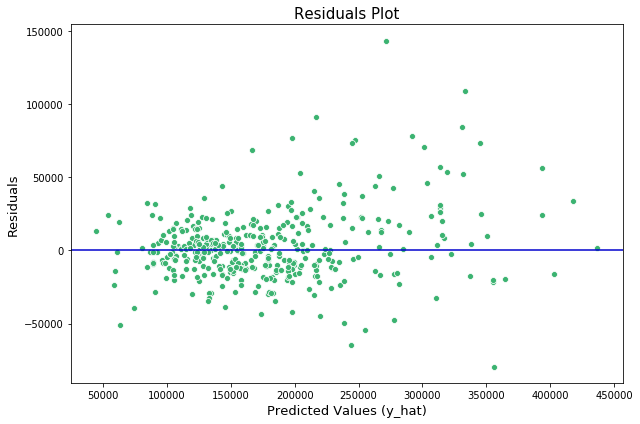

In [213]:
plt.figure(figsize=(9,6))
sns.scatterplot(x = y_pred, y = resids, color = 'mediumseagreen')
plt.axhline(0, color = 'mediumblue')
plt.title('Residuals Plot', fontdict = {'fontsize':15})
plt.xlabel('Predicted Values (y_hat)', fontdict = {'fontsize':13})
plt.ylabel('Residuals', fontdict = {'fontsize':13})
plt.tight_layout();

The poor performance of the model at predicting values less than \\$90,000 and greater than \\$225,000 is further amplified by this plot. The residuals increase at the more extreme predicted values. 

Because this plot appears to have a fan shape, it is indicative that this model did not have equality of variance between features. In EDA, I discovered that both the target (Sale Price) and most features were not normally distributed. To build the model, the Sale Price was log-transformed, but none of the features were transformed. Before deploying the model, we might consider log-transforming some of the features, too.

#### Distribution of Residuals

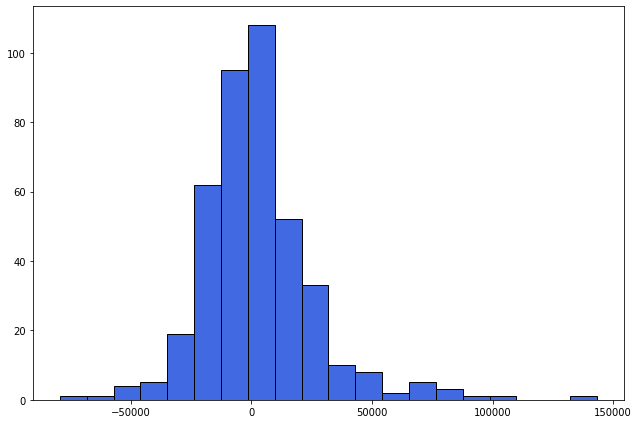

In [214]:
# Plot Graph 3
resids.hist(bins = 20, figsize = (9,6), edgecolor = 'black', grid = False, color = 'royalblue')
plt.tight_layout();

From the above histogram, it is evident that the residuals are not normally distributed. On both tails of the distribution, there are some residuals that indicate that the model's prediction was incorrect by quite a bit.

## Conclusions & Recommendations 

In [215]:
# https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/

lr1_coefs = pd.DataFrame((np.exp(lr1.coef_)-1)*100, X_train_3.columns, columns = ['Coefficient'])

Although the linear regression model that was created during this sprint, is not perfect, it is able to account for approximately 87.8% of the variation in Sale Price of a property, and it also is able to predict the Sale Price within \\$23,673.28. Further exploration of the residuals of this model revealed a specific weakness in this model at predicting extreme values. Specifically, the ideal range for predictions appeared to be within $90,000 to \\$225,000. In order to better predict prices outside of this range, changes will need to be made to the model.

However, based on the current model, insights about the contribution of specific features to Sale Price can be derived from this model. Holding all else constant, we expect that:
* Having paved access to the property will result in a 19.7% increase in sale price.
* Being located on a hillside will result in a 16.9% increase in sale price.
* Having a paved driveway will result in a 10.7% increase in sale price.
* Having an attached garage will result in a 9.4% increase in sale price. 
* Having a basement garage will result in a 9.4% increase in sale price.
* Having an excellent kitchen will result in a 8.9% increase in sale price
* Having a built-in garage will result in a 8.2% increase in sale price
* A one-unit increase in overall quality will result in an 8.2% increase in sale price.
* Having an exterior quality of fair will result in a 17% decrease in sale price.
* Having a townhouse will result in a 11.4% decrease in sale price. 
* Having a duplex will result in a 8.2% decrese in sale price.

From this model, it also appears that a property in the first cluster of neighborhoods results in a 7.5% increase in sale price. These neighborhoods are: Stone Brooke, Northridge Heights, Veenker, North Ridge, and Green Hill. 

## References

1. [Population of Ames Iowa](https://datausa.io/profile/geo/ames-ia/)
2. [City of Ames Website](https://www.cityofames.org/about-ames/about-ames)
3. [Machine Learning in Real Estate](https://unionstreetmedia.com/the-rise-of-machine-learning-in-real-estate/#:~:text=Personalized%20Marketing%20Automation%20%E2%80%93%20machine%20learning,neighborhood%20and%20property%20is%20best)
4. [Ames Housing Data - Original Article](#http://jse.amstat.org/v19n3/decock.pdf)